# Selección y Planteamiento del Problema

## Problema

Un sistema de salud necesita priorizar a los pacientes con mayor probabilidad de presentar el evento clínico asociado a **DiagPeriodL90D** (variable binaria 1/0 registrada en el dataset) para optimizar recursos de seguimiento, tamizaje e intervención temprana.  
No identificar a tiempo a estos pacientes implica mayor carga asistencial, costos y peores resultados clínicos.

El dataset disponible (`training.csv` y `test.csv`) contiene información histórica por paciente:

- **Demografía y cobertura:** `patient_age`, `patient_gender`, `patient_race`, `payer_type`, `patient_state`, `patient_zip3`, `Region`, `Division`.
- **Variables clínicas:** `breast_cancer_diagnosis_code`, `breast_cancer_diagnosis_desc`, `metastatic_cancer_diagnosis_code` (algunas con muy alta ausencia, p. ej., tratamientos “novel”).
- **Indicadores antropométricos:** `bmi` (alto % de nulos).
- **Contexto socioeconómico (geográfico):** ingresos del hogar (`income_household_*`, `income_household_median`, `six_figure`, etc.), empleo (`unemployment_rate`, `self_employed`, `family_dual_income`), vivienda (`home_ownership`, `home_value`, `rent_median`, `rent_burden`), pobreza (`poverty`), educación, `family_size`, `limited_english`, `farmer`.
- **Ambientales:** `Ozone`, `PM25`, `N02`.

La variable objetivo es **DiagPeriodL90D** (binaria). En `training.csv` la clase 1 representa ~62% y la clase 0 ~38% (ligero desbalance).

## Posible solución

Desarrollar un **modelo de clasificación** que prediga la probabilidad de `DiagPeriodL90D = 1` usando las variables demográficas, clínicas, socioeconómicas y ambientales disponibles.

El puntaje resultante permitirá:

- Priorizar a los pacientes con mayor riesgo para seguimiento o intervención temprana.
- Asignar recursos (cupos de evaluación, telemonitoreo) donde el beneficio esperado sea mayor.
- Definir umbrales de decisión (automatizar, derivar a revisión clínica o no intervenir).

## Enfoque técnico

### Integridad y llaves

- Usar `patient_id` como identificador para detectar duplicados y asegurar una fila por paciente (o definir llave compuesta si hubiera múltiples registros por período).

### Definición del objetivo

- `y := DiagPeriodL90D (1/0)`.
- Documentar claramente qué evento clínico codifica esta variable en la fuente (para alinear decisiones y umbrales).

### EDA y calidad de datos

- Asegurar tipos correctos (IDs/códigos como texto).
- **Nulos — Regla operativa aplicada en EDA:**
    - < 5% → eliminar filas o imputación simple.
    - 5% – 8% → imputación recomendada (mediana en numéricas, moda en categóricas).
    - > 8% → descartar columna, salvo que sea crucial (p. ej., descartar `metastatic_first_novel_treatment*` ~99.8% nulos; evaluar `bmi` y `patient_race` por su alto faltante).
- Revisar outliers y distribuciones (edad, bmi, ingresos, etc.).

In [2]:
import pandas as pd


pd.set_option('display.max_columns', None)


train = pd.read_csv("training.csv")
test = pd.read_csv("test.csv")

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


print("\nPrimeras filas del TRAIN:")
display(train.head())

print("\nPrimeras filas del TEST:")
display(test.head())


print("\nInformación TRAIN:")
print(train.info())

print("\nInformación TEST:")
print(test.info())


print("\nNulos en TRAIN:")
print(train.isnull().sum().sort_values(ascending=False).head(20))

print("\nNulos en TEST:")
print(test.isnull().sum().sort_values(ascending=False).head(20))


if "DiagPeriodL90D" in train.columns:
    print("\nDistribución de la variable objetivo:")
    print(train["DiagPeriodL90D"].value_counts(normalize=True))

Train shape: (12906, 83)
Test shape: (5792, 82)

Primeras filas del TRAIN:


,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,NaN,NaN,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.500000,2.646343e+05,1165.000000,37.442857,33.257143,29.200000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.100000,5.100000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,NaN,NaN,West,Pacific,39121.87879,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,13.333333,14.060606,10.248485,5.951515,3.503030,49.893939,50.106061,50.245455,9.827273,35.290909,4.651515,3.622727,61.736364,102741.63640,2.327273,1.536364,2.648485,2.178788,2.409091,5.163636,7.972727,13.936364,12.469697,19.760606,29.596970,49.357576,41287.27273,61.463636,11725.666670,6.776885e+05,2003.125000,34.753125,14.230303,19.987879,29.796970,23.739394,12.245455,35.984848,47.918182,65.230303,5.103030,15.224242,0.027273,54.030303,2.527273,20.827273,0.587879,0.300000,11.645455,10.081818,37.948485,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,C773,NaN,NaN,South,West South Central,21996.68333,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,12.860000,12.770000,11.426667,6.565000,2.811667,50.123333,49.876667,55.753333,12.330000,27.195000,4.710000,3.260667,55.801667,85984.74138,2.483333,1.305000,2.716667,2.938333,2.766667,6.763333,12.061667,15.835000,13.560000,20.875000,18.680000,39.555000,40399.03333,72.745000,7786.583333,2.377131e+05,1235.907407,29.358491,10.811667,27.038333,32.368333,19.678333,10.115000,29.793333,37.308475,66.428333,4.560000,13.722034,3.650847,75.820000,9.231667,3.618333,0.463333,0.146667,3.816667,6.898333,19.370000,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,NaN,NaN,West,Pacific,32795.32558,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,12.650000,14.847619,12.280952,8.216667,4.759524,49.066667,50.933333,52.604762,11.623810,31.142857,4.62


Primeras filas del TEST:


,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
0,573710,White,MEDICAID,IN,467,54,F,NaN,C50412,Malig neoplasm of upper-outer quadrant of left...,C773,NaN,NaN,Midwest,East North Central,5441.435484,85.620968,40.880328,12.732258,14.088710,10.659677,11.625806,11.208065,15.619355,12.322581,8.409677,3.343548,49.154839,50.845161,55.175806,13.982258,24.266129,6.583871,3.073226,52.980645,66187.22807,1.611290,1.277419,2.645161,3.853226,3.172581,13.275806,12.633871,21.485484,16.717742,15.238710,8.070968,23.309677,33553.43333,84.112903,2064.741935,152749.5370,825.122449,23.895455,12.429032,40.667742,28.959677,11.895161,6.046774,17.941935,35.591379,63.303226,3.406557,10.655357,5.551786,94.793548,0.364516,0.303226,0.119355,0.009677,0.770968,3.630645,3.564516,13.996774,7.985484,0.969355,24.955357,10.838710,8.080645,38.724876,7.947165,11.157161
1,593679,NaN,COMMERCIAL,FL,337,52,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,C787,NaN,NaN,South,South Atlantic,19613.820510,1555.107692,49.107692,8.069231,8.587179,10.684615,11.302564,10.971795,15.823077,15.902564,11.828205,6.815385,49.658974,50.341026,44.800000,17.779487,29.102564,8.310256,2.917105,46.665789,64711.71053,3.873684,2.044737,3.807895,4.239474,4.242105,9.347368,13.018421,17.373684,12.889474,14.442105,14.702632,29.144737,34678.61538,68.673684,8502.230769,265860.6053,1343.394737,34.957895,8.379487,26.558974,30.200000,22.100000,12.764103,34.864103,43.250000,57.035897,5.002632,11.564103,0.005128,78.217949,10.889744,3.453846,0.187179,0.076923,1.841026,5.328205,10.261538,16.020513,13.602564,2.836842,23.952632,10.579487,9.302564,36.918257,7.838973,13.599985
2,184532,Hispanic,MEDICAID,CA,917,61,F,NaN,C50911,Malignant neoplasm of unsp site of right femal...,C773,NaN,NaN,West,Pacific,43030.500000,2048.578261,38.852174,11.306522,12.897826,14.121739,13.532609,13.160870,13.378261,11.473913,6.380435,3.736957,49.052174,50.947826,48.504348,10.117391,36.408696,4.969565,3.674783,59.219565,86330.39130,2.226087,1.528261,2.897826,2.747826,3.173913,6.647826,9.617391,15.965217,13.589130,19.752174,21.847826,41.600000,34317.82609,61.397826,12609.260870,572606.5000,1778.000000,34.595652,17.491304,22.656522,29.263043,20.200000,10.404348,30.604348,46.208696,63.154348,6.197826,15.708696,0.015217,38.708696,3.963043,25.565217,1.193478,0.269565,18.858696,11.426087,47.726087,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,47.310325,9.595719,20.084231
3,447383,Hispanic,MEDICARE ADVANTAGE,CA,917,64,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,C779,NaN,NaN,West,Pacific,43030.500000,2048.578261,38.852174,11.306522,12.897826,14.121739,13.532609,13.160870,13.378261,11.473913,6.380435,3.736957,49.052174,50.947826,48.504348,10.117391,36.408696,4.969565,3.6


Información TRAIN:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-n

Analisis exploratorio

In [8]:
dup_patient_train = train.duplicated(subset=["patient_id"]).sum()
dup_patient_test  = test.duplicated(subset=["patient_id"]).sum()

print(f"Duplicados en TRAIN por patient_id: {dup_patient_train}")
print(f"Duplicados en TEST  por patient_id: {dup_patient_test}")


if "DiagPeriodL90D" in train.columns:
    dup_combo_train = train.duplicated(subset=["patient_id","DiagPeriodL90D"]).sum()
    print(f"Duplicados en TRAIN por patient_id + DiagPeriodL90D: {dup_combo_train}")

if dup_patient_train > 0:
    display(train[train.duplicated(subset=["patient_id"], keep=False)].sort_values("patient_id").head(10))

Duplicados en TRAIN por patient_id: 0
Duplicados en TEST  por patient_id: 0
Duplicados en TRAIN por patient_id + DiagPeriodL90D: 0


In [9]:
# 2.2.- Analizando y corrigiendo tipos de datos (IDs y códigos como string)
cols_as_str = [c for c in ["patient_id", "patient_zip3",
                           "breast_cancer_diagnosis_code",
                           "metastatic_cancer_diagnosis_code"] if c in train.columns]

for c in cols_as_str:
    train[c] = train[c].astype(str)
    if c in test.columns:
        test[c] = test[c].astype(str)

train.dtypes.head(20)

patient_id                                object
patient_race                              object
payer_type                                object
patient_state                             object
patient_zip3                              object
patient_age                                int64
patient_gender                            object
bmi                                      float64
breast_cancer_diagnosis_code              object
breast_cancer_diagnosis_desc              object
metastatic_cancer_diagnosis_code          object
metastatic_first_novel_treatment          object
metastatic_first_novel_treatment_type     object
Region                                    object
Division                                  object
population                               float64
density                                  float64
age_median                               float64
age_under_10                             float64
age_10_to_19                             float64
dtype: object

### Analizando medidas de Posición y dispersión

#### Variables numéricas

* ¿Qué implica que la media sea similar, mayor o menor a la mediana?
* ¿Qué implica que la desviación estandar sea mayor o menor que la media?
* Determinar el rango para 2 variables
* ¿Cómo se relacionan los cuartiles con los percentiles? Interpreta los valores para 2 variables
* ¿Qué implica que el cuartil 1 y 2 sean muy similares?

1. ¿Qué implica que la media sea similar, mayor o menor a la mediana?

Media ≈ Mediana: la distribución es simétrica (ej. edad de pacientes si está balanceada).

Media > Mediana: hay sesgo a la derecha (outliers altos elevan la media).

Media < Mediana: hay sesgo a la izquierda (outliers bajos reducen la media).

👉 Ejemplo: si en patient_age la media y mediana están cercanas (digamos 55 y 54), la edad está bien distribuida.
Si en bmi la media es mucho mayor que la mediana (ej. 30 vs 26), significa que hay pacientes con valores muy altos de IMC que “jalan” la media hacia arriba.

🔹 2. ¿Qué implica que la desviación estándar sea mayor o menor que la media?

Desv. estándar baja (menor que la media): los datos están concentrados cerca del promedio.

Desv. estándar alta (comparable o mayor que la media): hay mucha dispersión o outliers extremos.

👉 Ejemplo:

En income_household_median si media = 50,000 y std = 5,000 → homogéneo.

Si media = 20 y std = 25 (ej. poverty en %), la dispersión es muy grande comparada al valor medio.

3. Determinar el rango para 2 variables

In [12]:
print("Rango de patient_age:", train["patient_age"].max() - train["patient_age"].min())
print("Rango de bmi:", train["bmi"].max() - train["bmi"].min())

Rango de patient_age: 73
Rango de bmi: 71.0


4. ¿Cómo se relacionan los cuartiles con los percentiles?

Los cuartiles son percentiles especiales:

Q1 = P25

Q2 = P50 (la mediana)

Q3 = P75

👉 Ejemplo:

Si en income_household_median, Q1=30,000; Q2=45,000; Q3=60,000:

El 25% más pobre tiene ingresos ≤30,000.

El 50% está por debajo de 45,000.

El 75% está por debajo de 60,000.

5. ¿Qué implica que el cuartil 1 y 2 sean muy similares?

Significa que entre el 25% y 50% de los datos los valores casi no cambian → hay concentración en ese rango.

Ejemplo: si en patient_age Q1=52 y Q2=54 → muchos pacientes tienen edades similares alrededor de 52–54.

Puede implicar que la distribución tiene una “meseta” o grupo muy denso en el medio.

In [11]:
import numpy as np
# Medidas de posición y dispersión
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train.select_dtypes(exclude=[np.number]).columns.tolist()

print("=== Descripción numérica TRAIN ===")
display(train[num_cols].describe().T)

print("=== Descripción categórica TRAIN ===")
display(train[cat_cols].describe().T)


=== Descripción numérica TRAIN ===


,count,mean,std,min,25%,50%,75%,max
patient_age,12906.0,59.183326,13.335216,18.000000,50.000000,59.000000,67.000000,91.000000
bmi,3941.0,28.984539,5.696906,14.000000,24.660000,28.190000,32.920000,85.000000
population,12905.0,20744.441237,13886.903756,635.545455,9463.896552,19154.190480,30021.278690,71374.131580
density,12905.0,1581.950419,2966.305306,0.916667,171.857143,700.337500,1666.515385,21172.000000
age_median,12905.0,40.502259,4.036963,20.600000,37.129825,40.639344,42.934783,54.570000
...,...,...,...,...,...,...,...,...
veteran,12905.0,7.083376,3.109022,1.200000,4.929688,6.847059,8.620000,25.200000
Ozone,12877.0,39.822352,3.559492,30.939316,37.698880,39.108249,41.136513,52.237210
PM25,12877.0,7.475221,1.516499,2.636008,6.651215,7.686577,8.276922,11.169408
N02,12877.0,16.098988,5.842501,2.760371,11.280694,15.589148,20.801880,31.504775


=== Descripción categórica TRAIN ===


,count,unique,top,freq
patient_id,12906,12906,179597,1
patient_race,6521,5,White,3588
payer_type,11103,3,COMMERCIAL,6032
patient_state,12855,50,CA,2438
patient_zip3,12906,739,900,239
patient_gender,12906,1,F,12906
breast_cancer_diagnosis_code,12906,50,1749,1982
breast_cancer_diagnosis_desc,12906,50,"Malignant neoplasm of breast (female), unspeci...",1982
metastatic_cancer_diagnosis_code,12906,43,C773,7052
metastatic_first_novel_treatment,24,2,PEMBROLIZUMAB,13


#### Variables Categóricas

* ¿Cuál es la ditribución de cada variable?
* ¿Cúal es la moda de cada variable?

In [17]:
# Filtrar solo las columnas categóricas
cat_cols = train.select_dtypes(include='object').columns
print(cat_cols)

# Sacando de la lista de análisis a las columns ID
cat_cols = list(cat_cols)
cat_cols.remove('patient_id')

cat_cols

Index(['patient_id', 'patient_race', 'payer_type', 'patient_state',
       'patient_zip3', 'patient_gender', 'breast_cancer_diagnosis_code',
       'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code',
       'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division'],
      dtype='object')


['patient_race',
 'payer_type',
 'patient_state',
 'patient_zip3',
 'patient_gender',
 'breast_cancer_diagnosis_code',
 'breast_cancer_diagnosis_desc',
 'metastatic_cancer_diagnosis_code',
 'metastatic_first_novel_treatment',
 'metastatic_first_novel_treatment_type',
 'Region',
 'Division']

In [19]:
# Analizando la distribución de 1 variable:

dist_valores = train['patient_race'].value_counts() #.nlargest(10)
print(dist_valores)
print("\n")

dist_porcent = train['patient_race'].value_counts(normalize=True).nlargest(10)*100
print(dist_porcent)

patient_race
White       3588
Black       1056
Hispanic     829
Other        683
Asian        365
Name: count, dtype: int64


patient_race
White       55.022236
Black       16.193835
Hispanic    12.712774
Other       10.473854
Asian        5.597301
Name: proportion, dtype: float64


In [20]:
def resumen_categorias(dataframe):
    for col in dataframe.select_dtypes(include='object').columns:
        total_categorias = len(dataframe[col].unique())
        print(f"Columna: {col}, Total de Categorías: {total_categorias}")

        top_10 = dataframe[col].value_counts().nlargest(10)
        porcentaje_top_10 = dataframe[col].value_counts(normalize=True).nlargest(10)* 100

        tabla_resumen = pd.DataFrame({
            'Categoría': top_10.index,
            'Cantidad': top_10.values,
            'Porcentaje': porcentaje_top_10.values
        })

        print(tabla_resumen)
        print("\n")

resumen_categorias(train[cat_cols])

Columna: patient_race, Total de Categorías: 6
  Categoría  Cantidad  Porcentaje
0     White      3588   55.022236
1     Black      1056   16.193835
2  Hispanic       829   12.712774
3     Other       683   10.473854
4     Asian       365    5.597301


Columna: payer_type, Total de Categorías: 4
            Categoría  Cantidad  Porcentaje
0          COMMERCIAL      6032   54.327659
1            MEDICAID      2569   23.137891
2  MEDICARE ADVANTAGE      2502   22.534450


Columna: patient_state, Total de Categorías: 51
  Categoría  Cantidad  Porcentaje
0        CA      2438   18.965383
1        TX      1155    8.984831
2        NY      1041    8.098016
3        MI       858    6.674446
4        IL       782    6.083236
5        OH       754    5.865422
6        FL       609    4.737456
7        GA       551    4.286270
8        PA       483    3.757293
9        MN       377    2.932711


Columna: patient_zip3, Total de Categorías: 739
  Categoría  Cantidad  Porcentaje
0       900       23

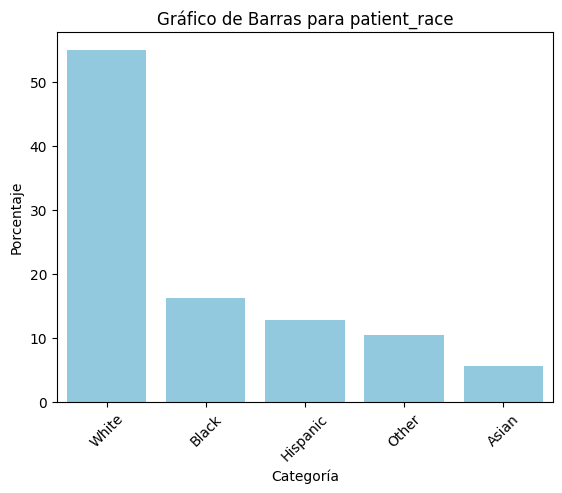

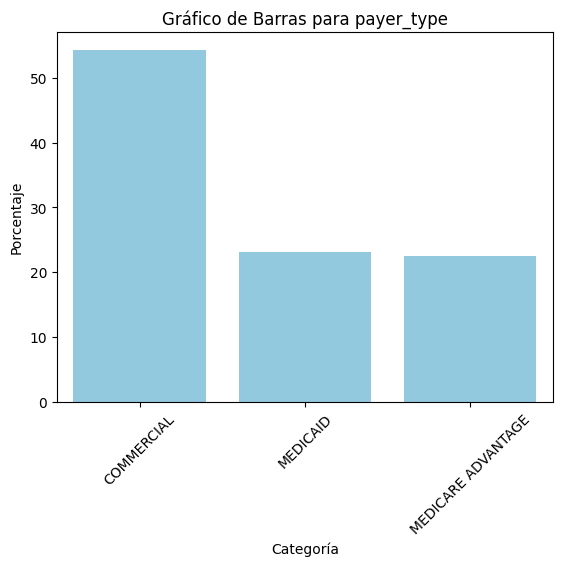

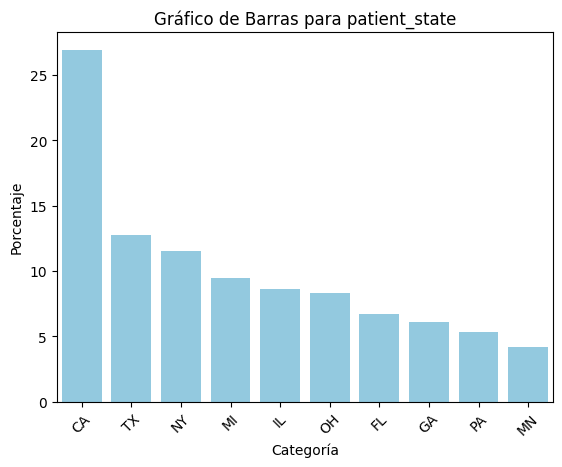

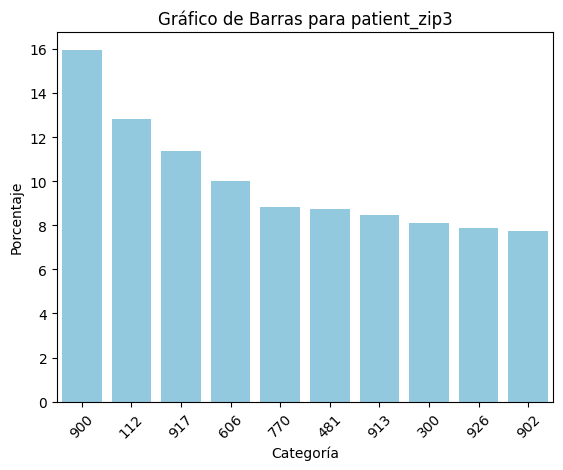

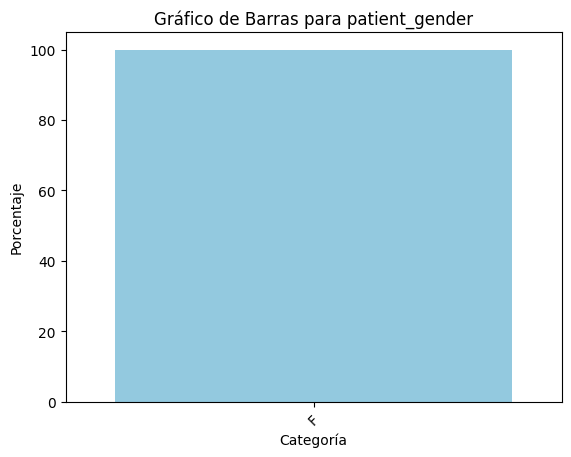

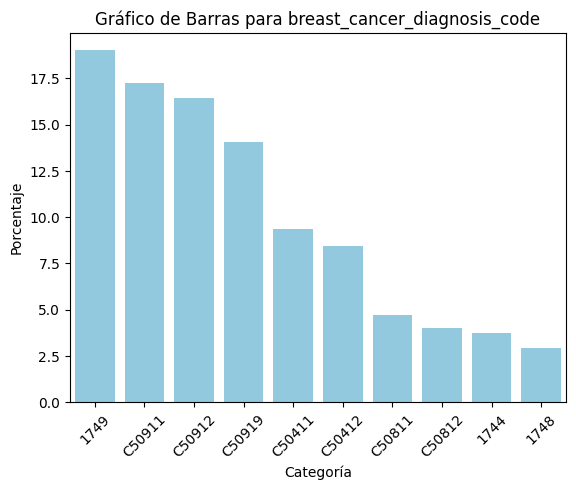

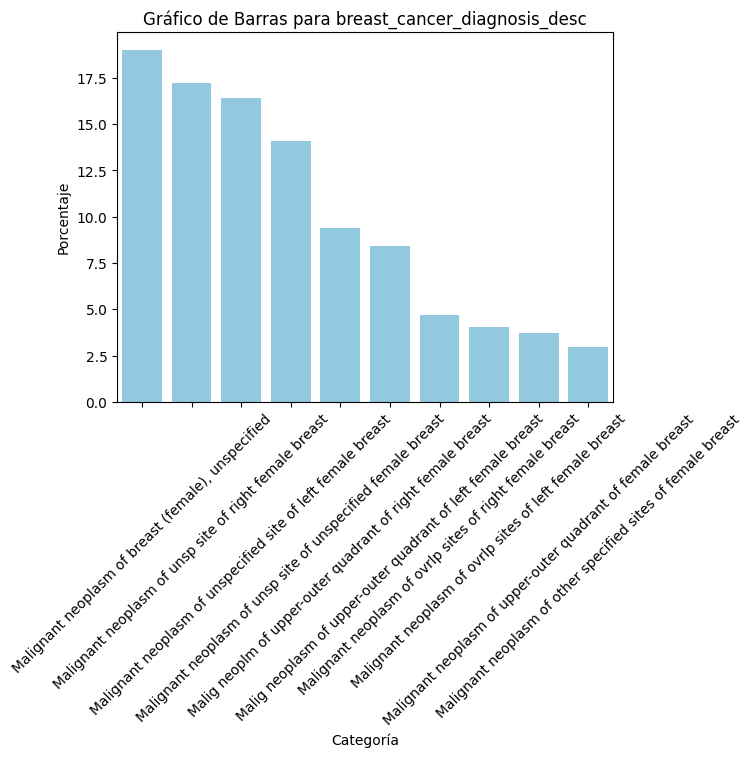

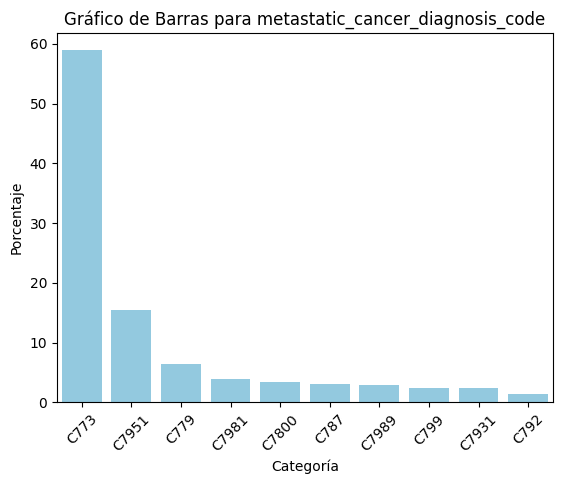

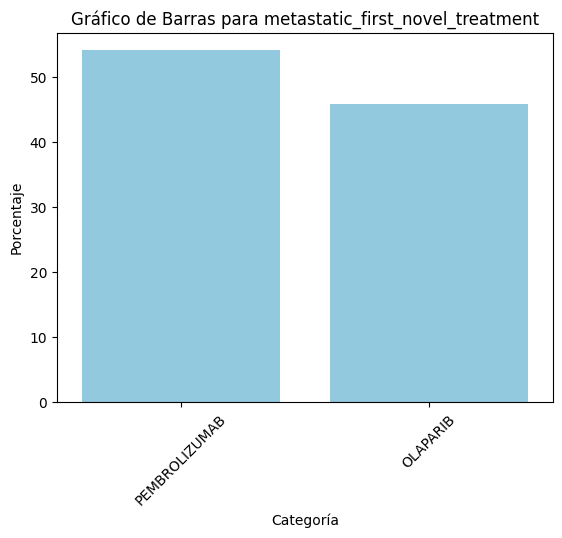

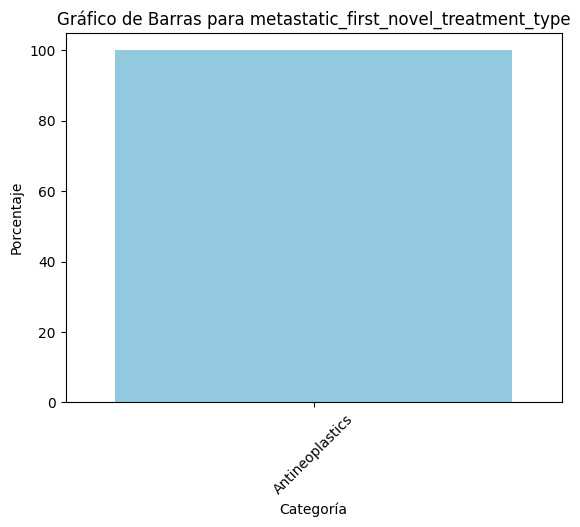

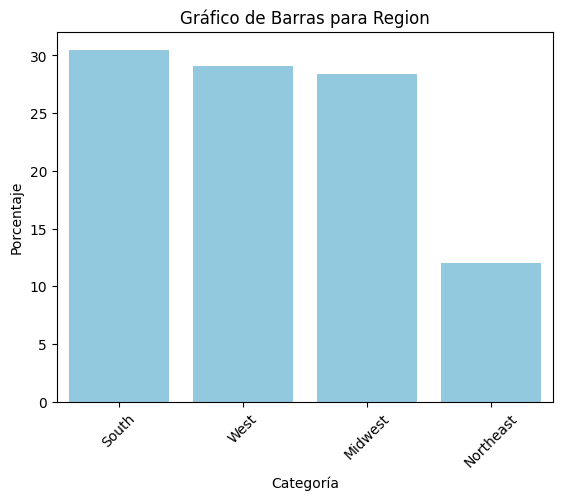

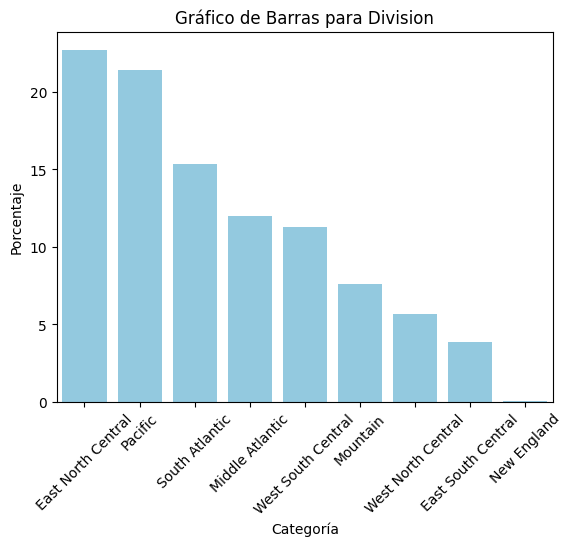

In [27]:
# Obtener el porcentaje de cada categoría para cada columna categórica
import matplotlib.pyplot as plt
import seaborn as sns
for col in cat_cols:
    plt.figure()  # Crear una nueva figura para cada gráfico
    top_categories = train[col].value_counts().nlargest(10).index
    df_top10 = train[train[col].isin(top_categories)][col]
    sns.barplot(x= df_top10.value_counts(normalize=True).index,
            y=df_top10.value_counts(normalize=True) * 100, color='skyblue')
    plt.title(f'Gráfico de Barras para {col}')
    plt.xlabel('Categoría')
    plt.ylabel('Porcentaje')
    plt.xticks(rotation=45)  # Rotar los nombres de categorías
    plt.show()

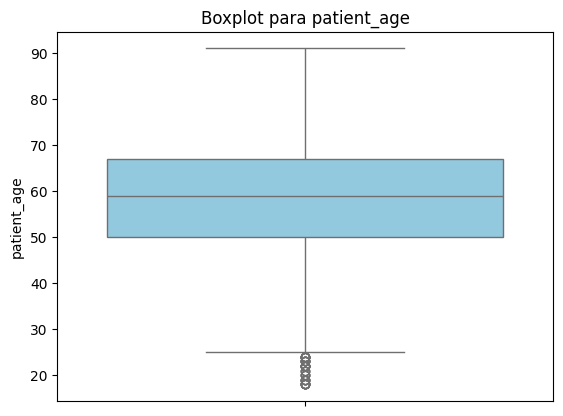

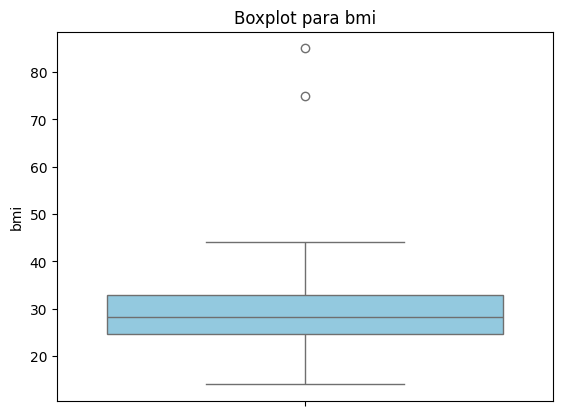

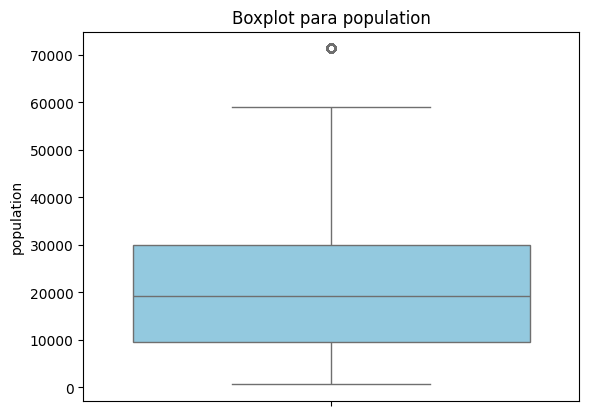

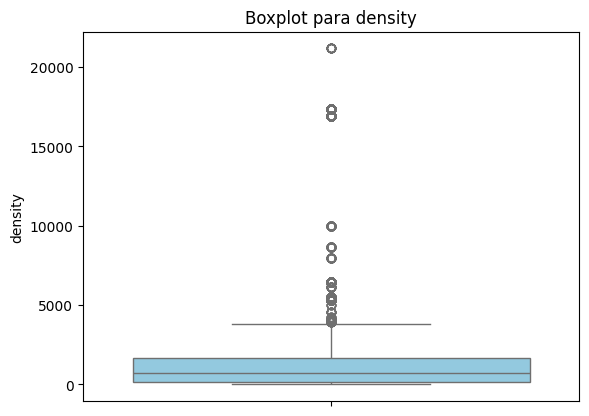

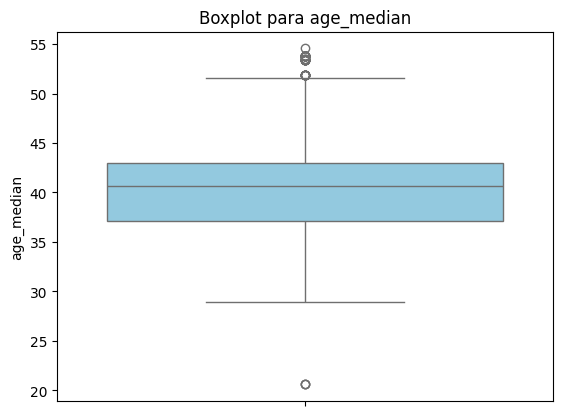

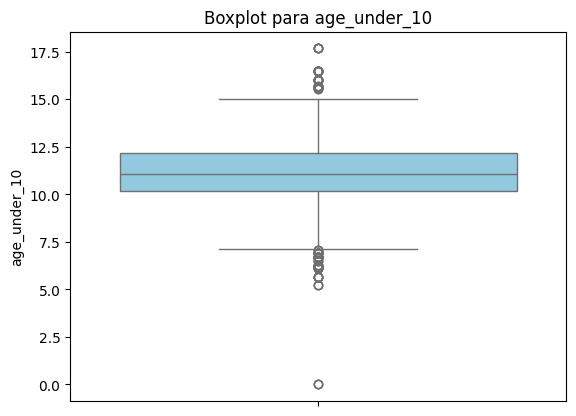

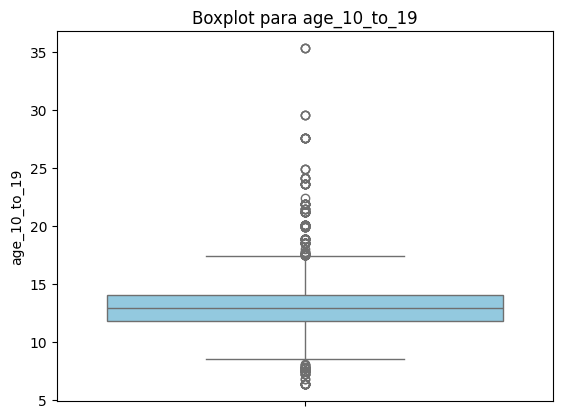

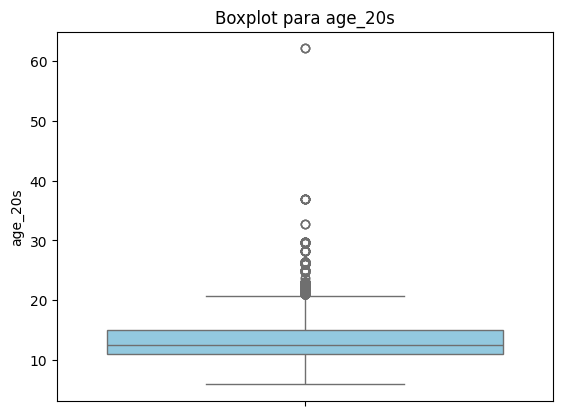

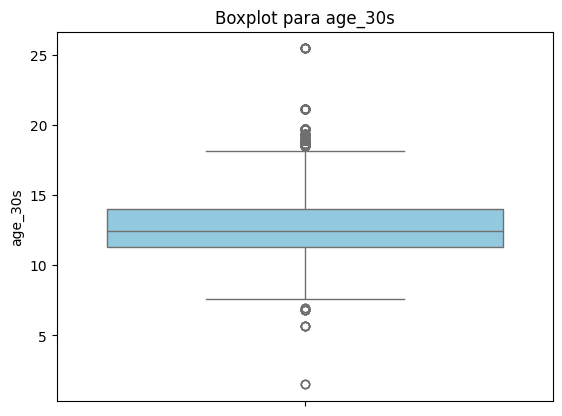

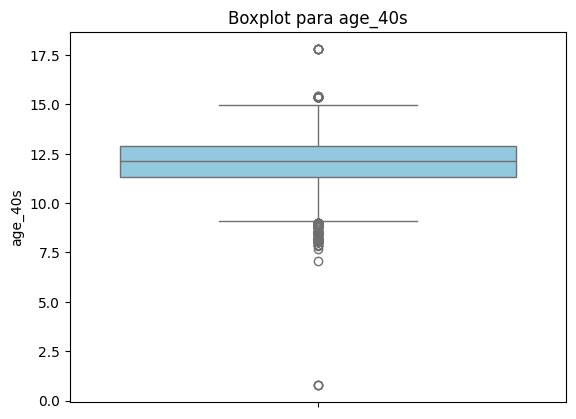

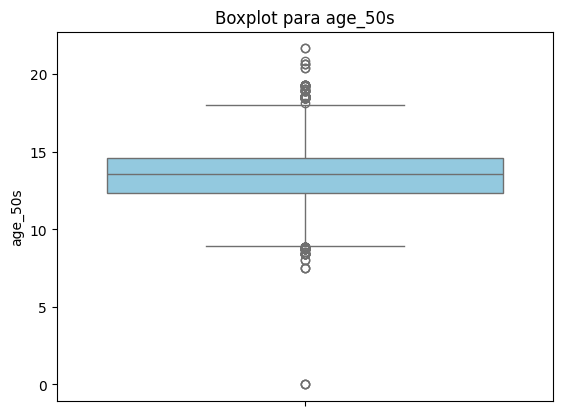

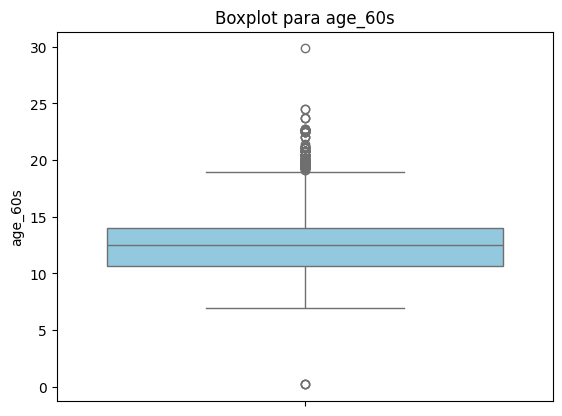

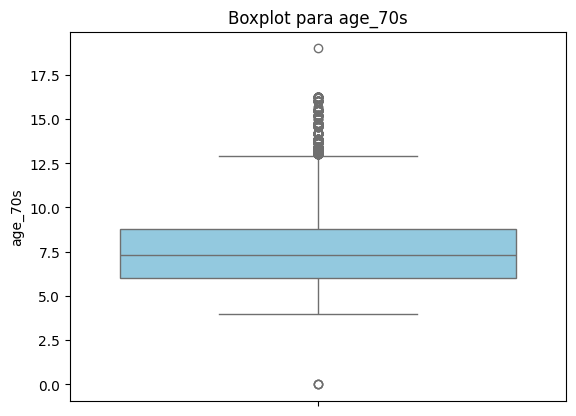

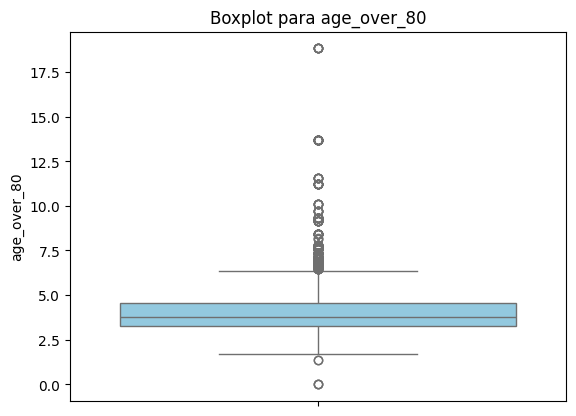

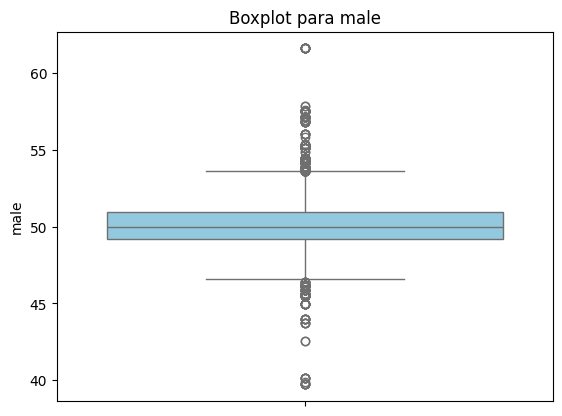

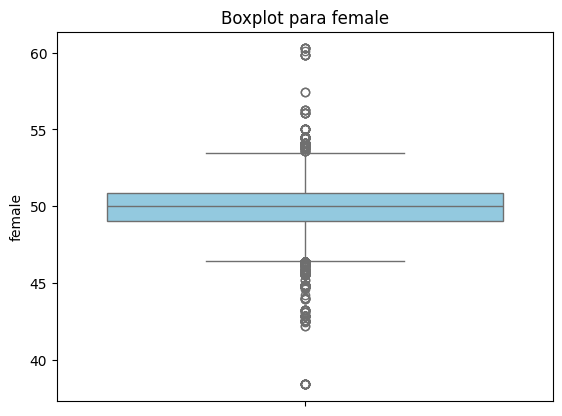

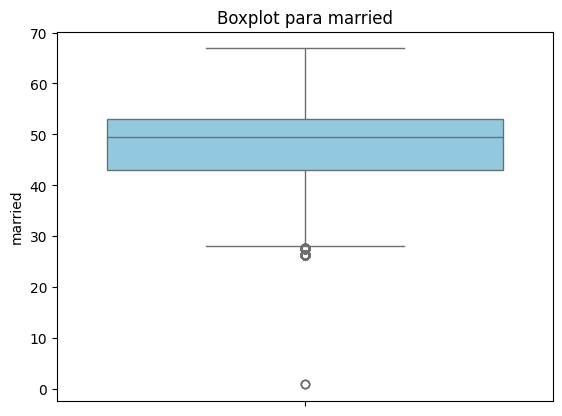

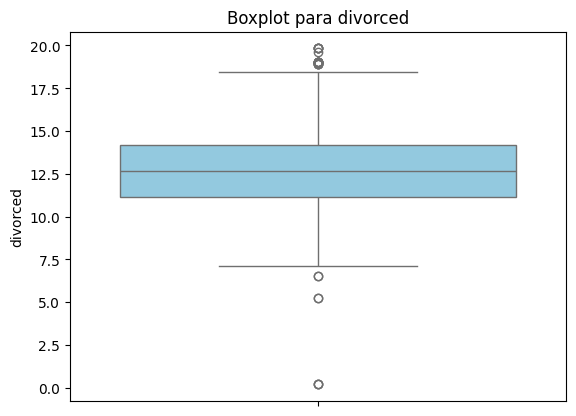

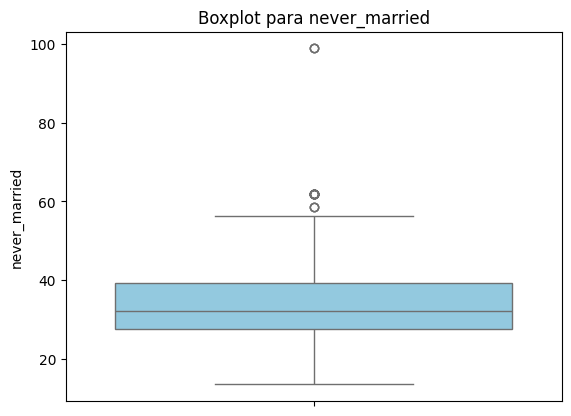

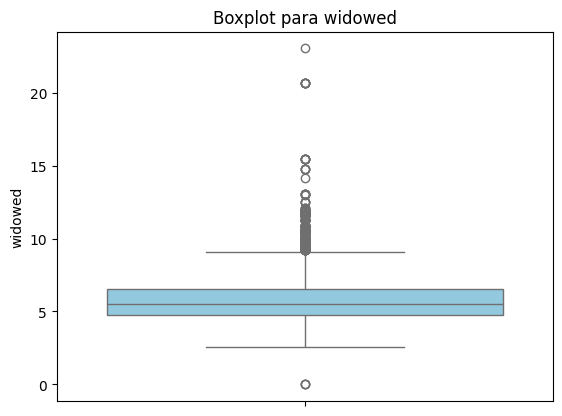

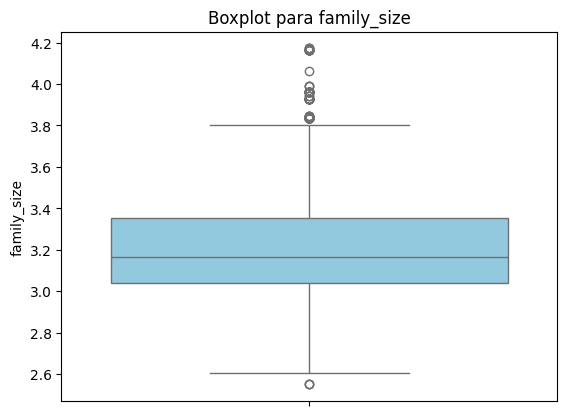

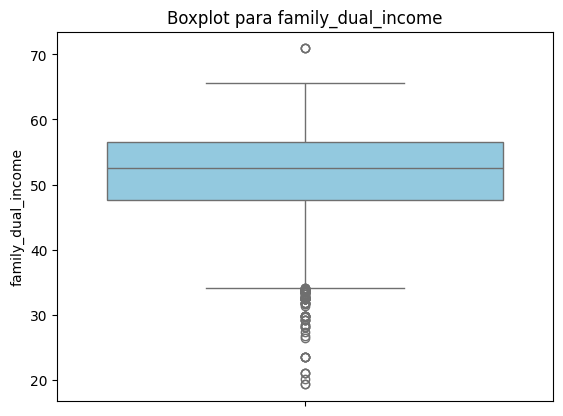

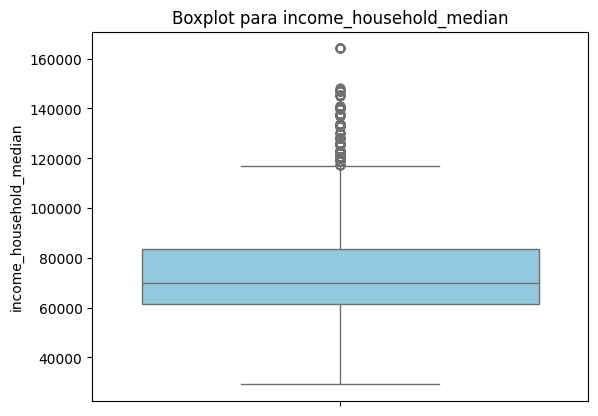

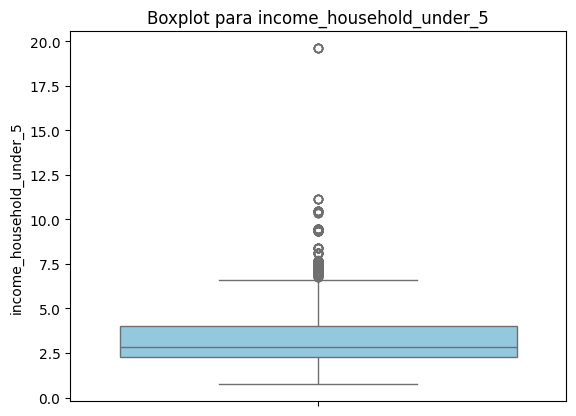

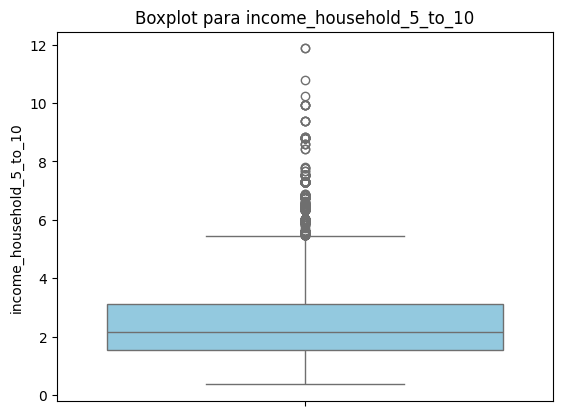

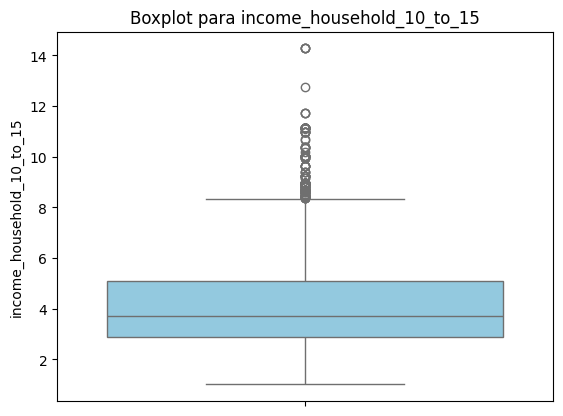

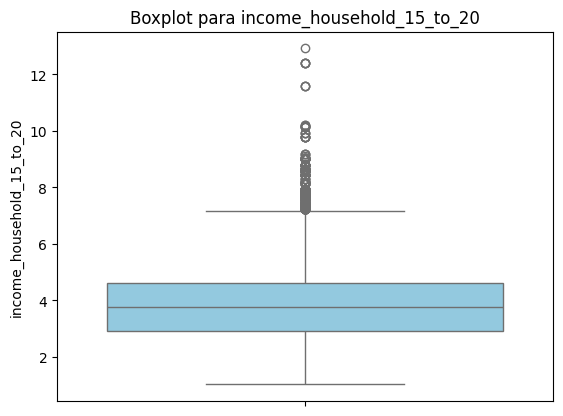

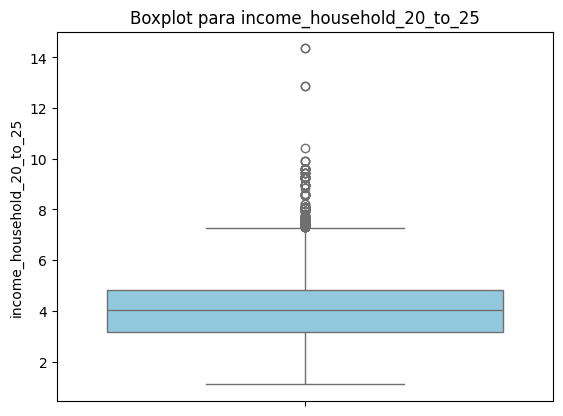

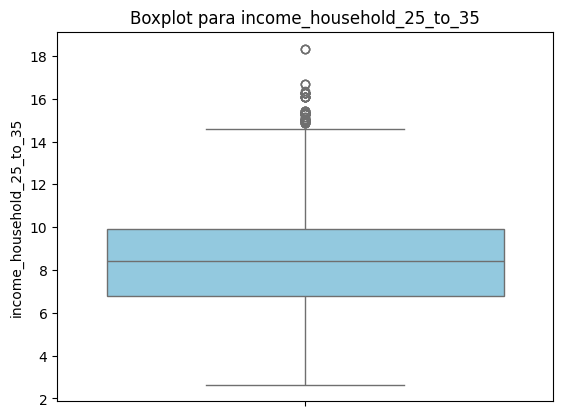

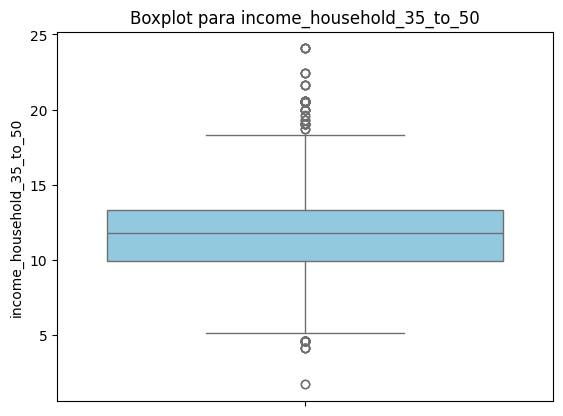

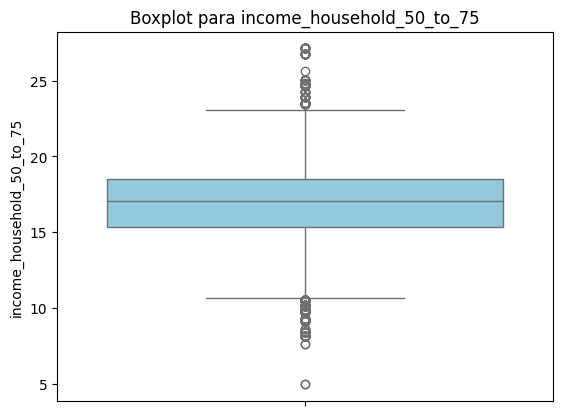

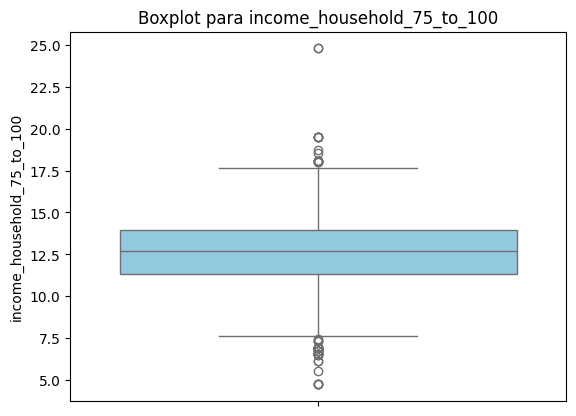

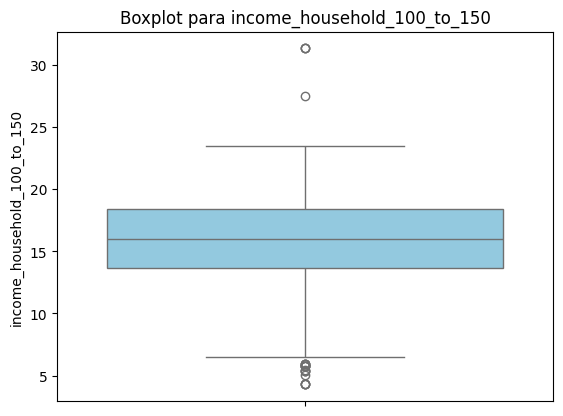

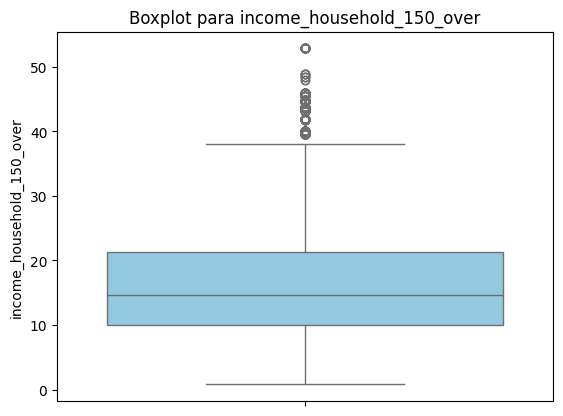

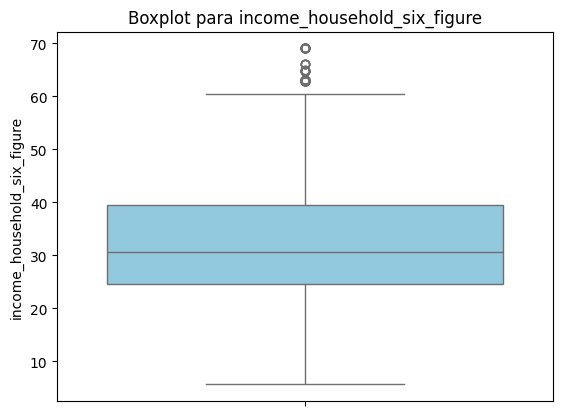

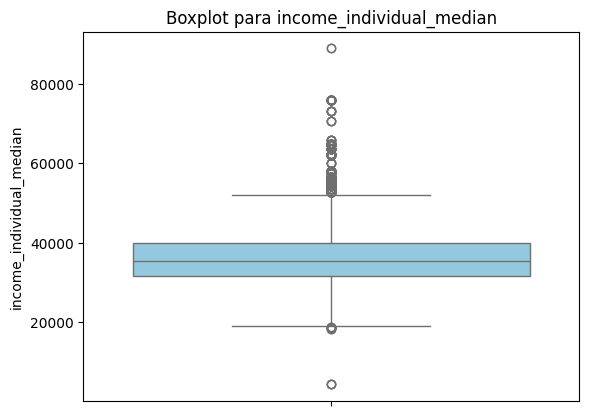

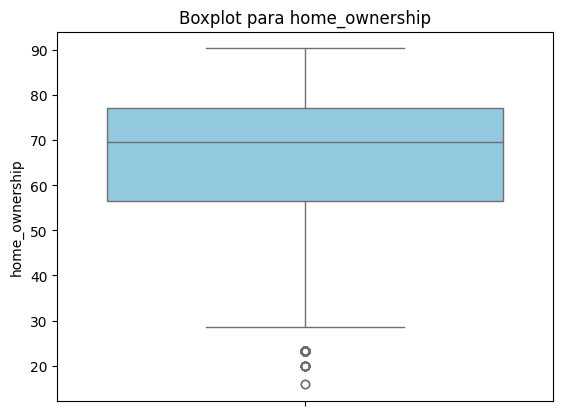

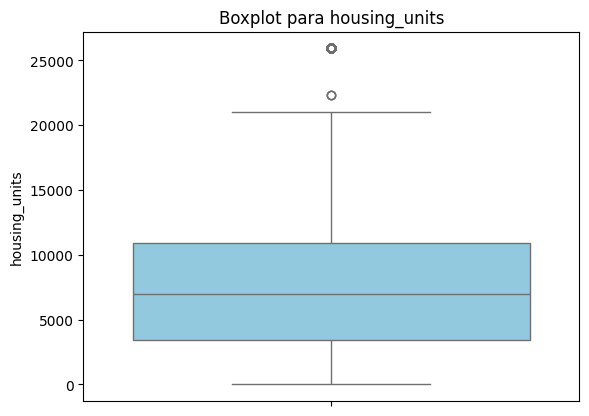

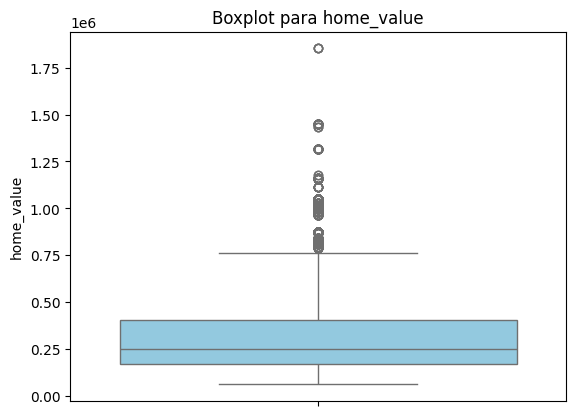

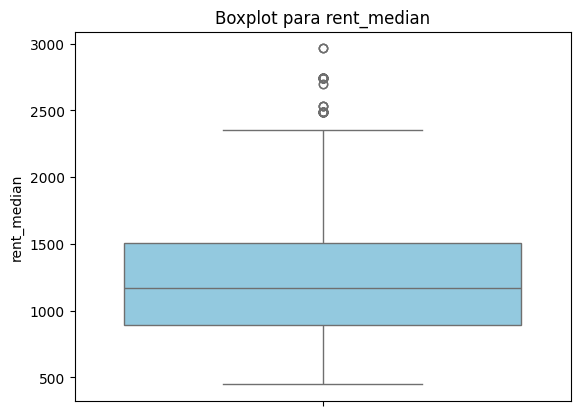

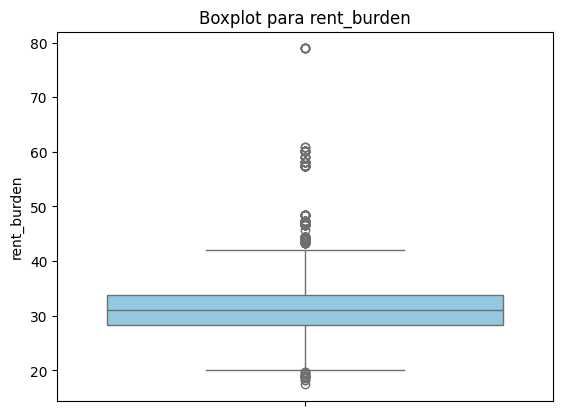

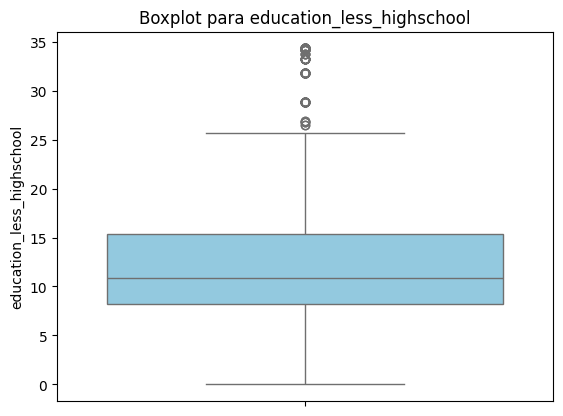

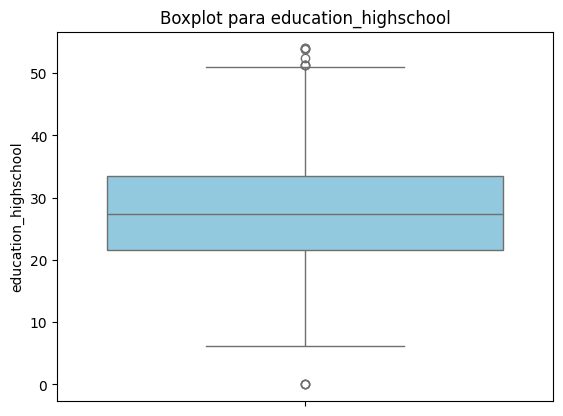

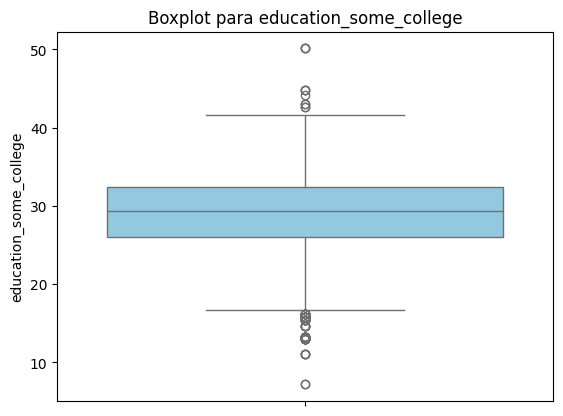

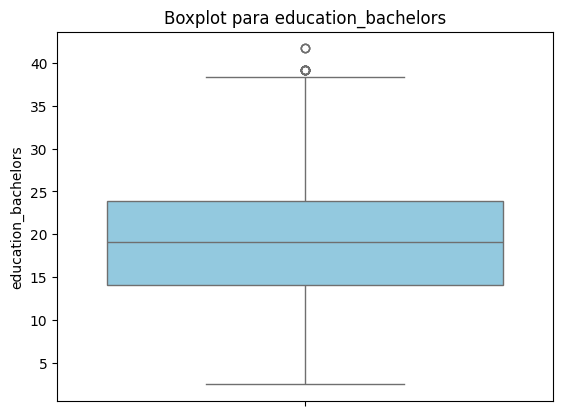

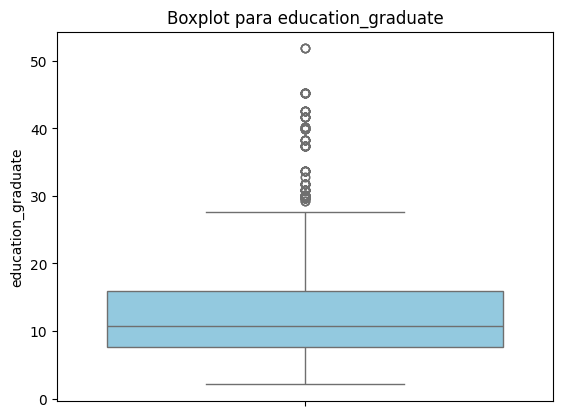

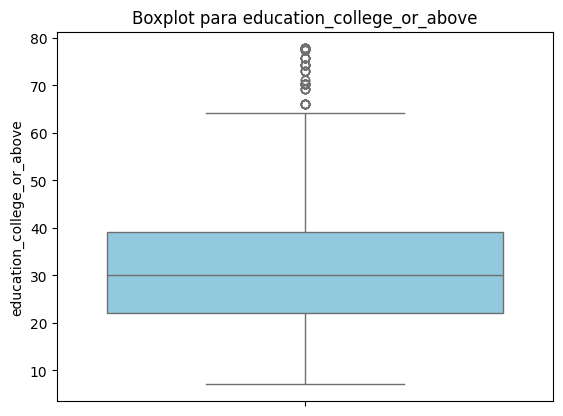

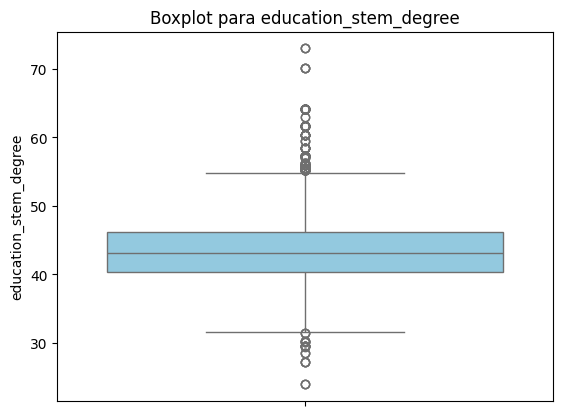

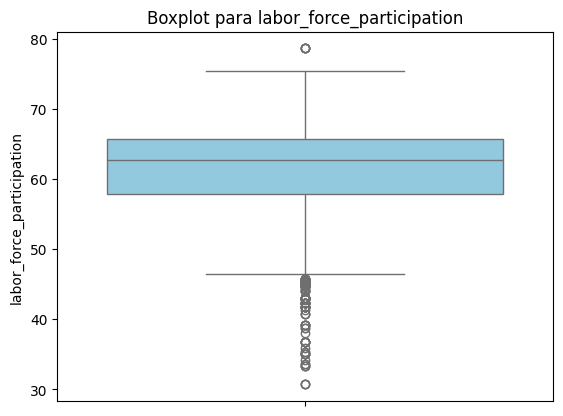

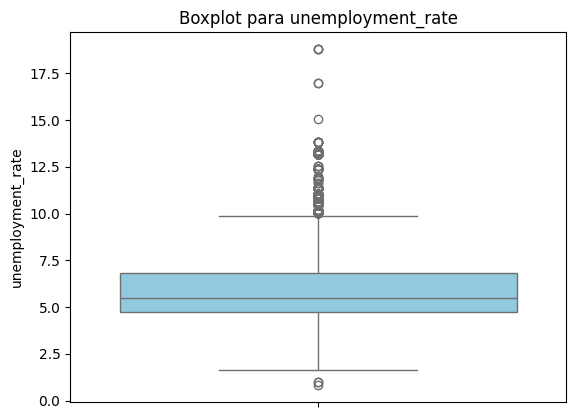

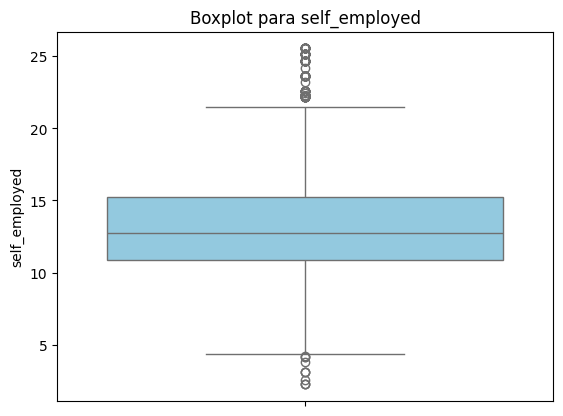

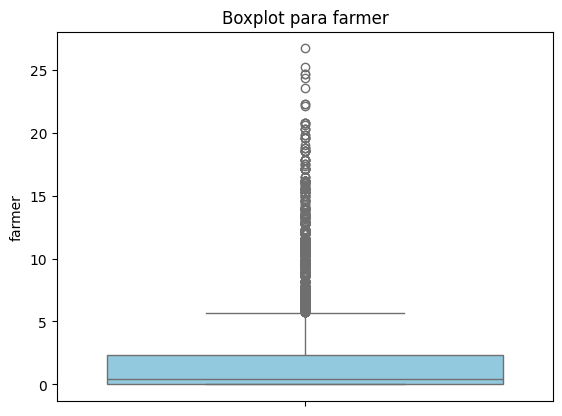

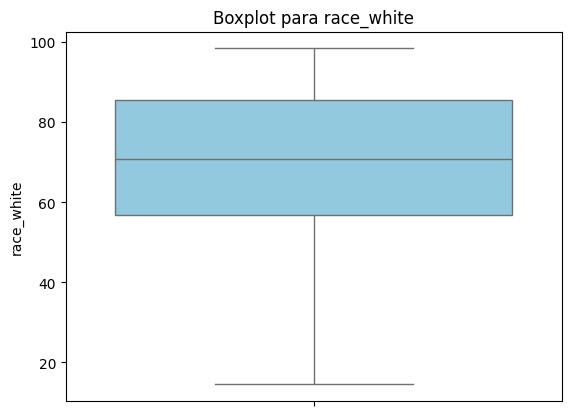

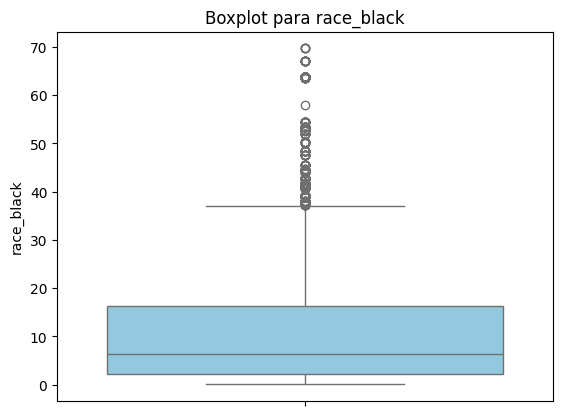

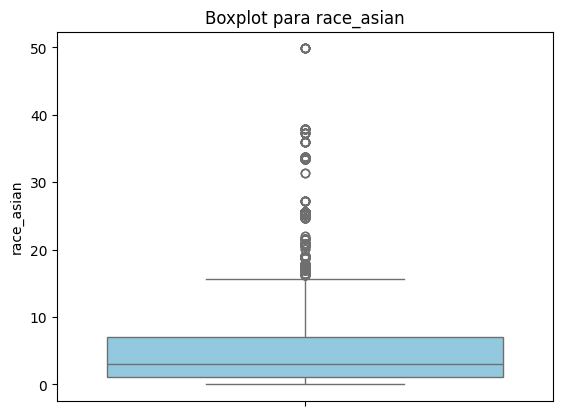

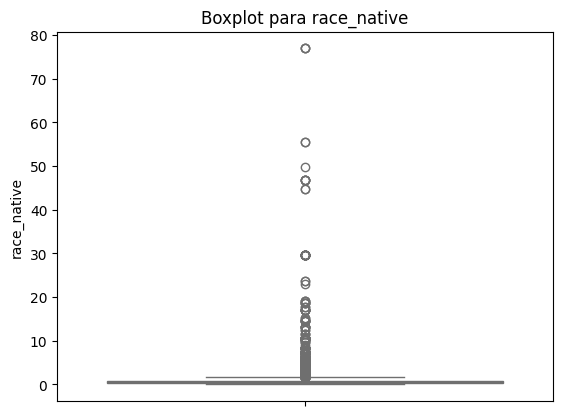

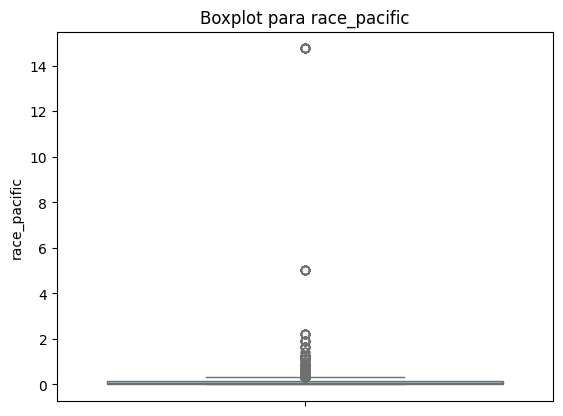

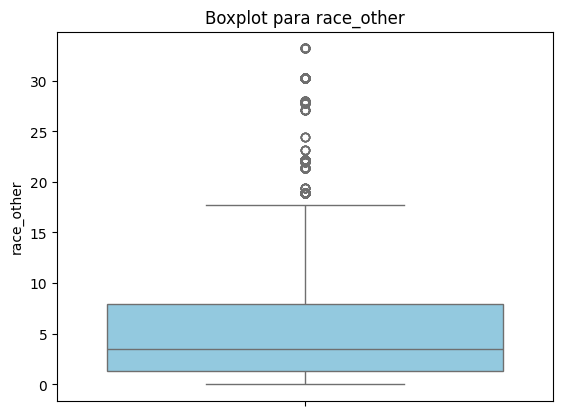

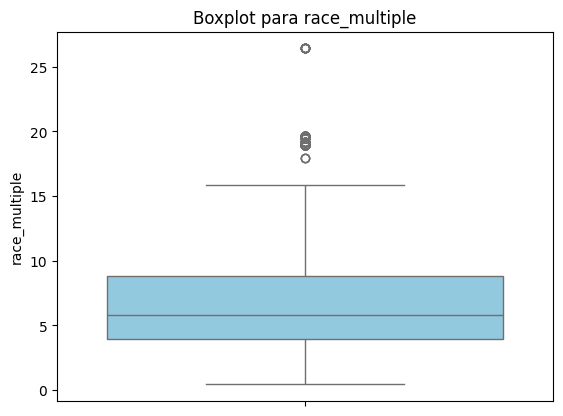

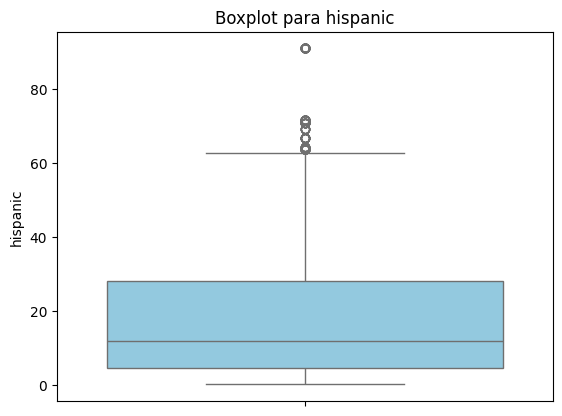

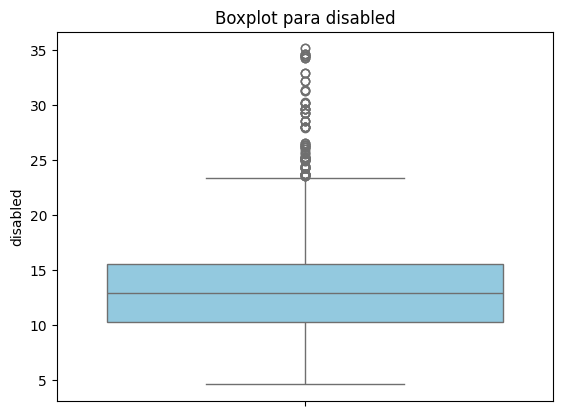

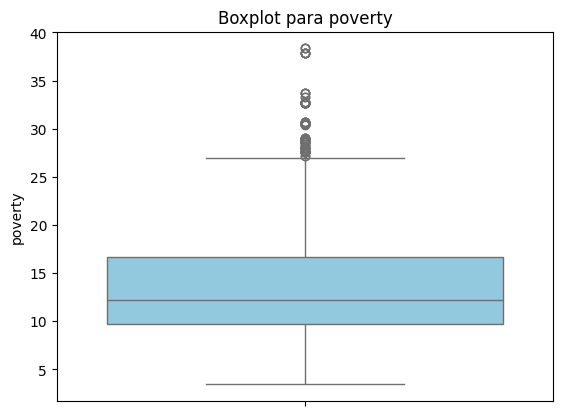

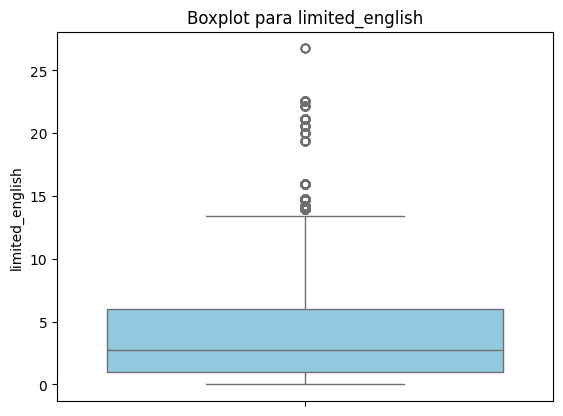

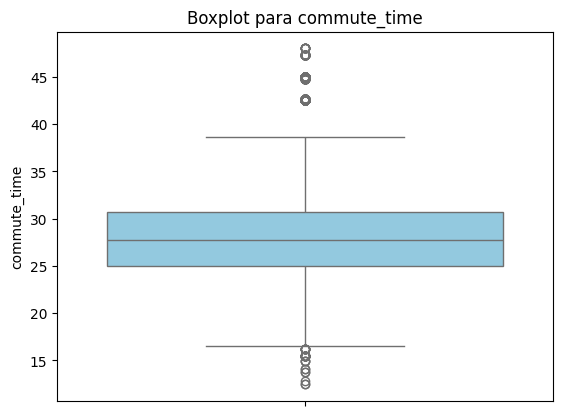

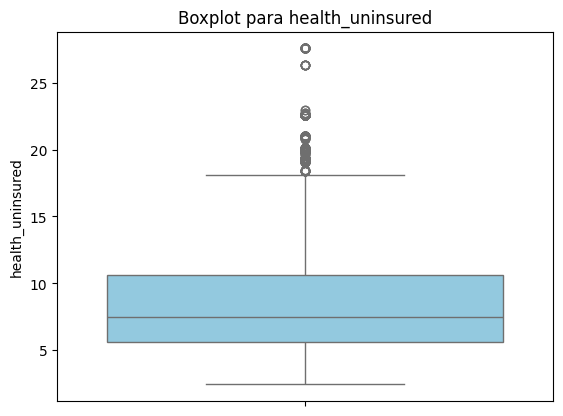

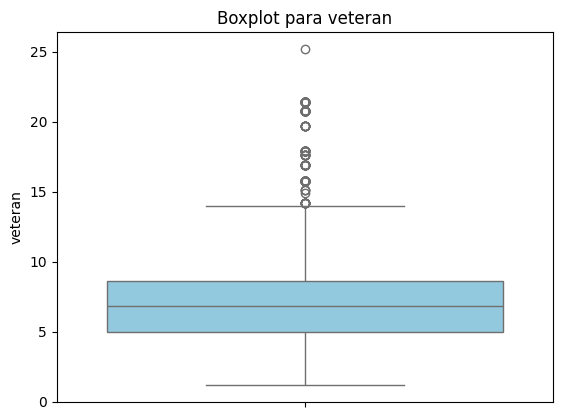

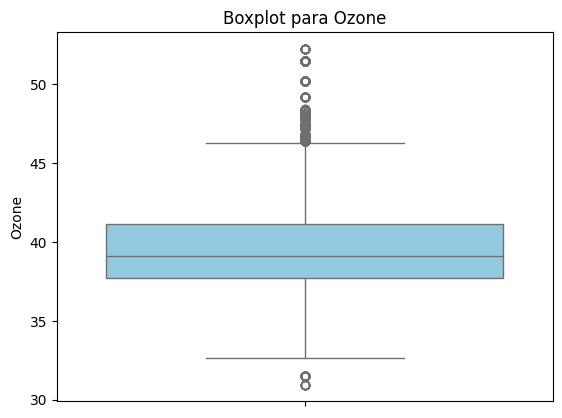

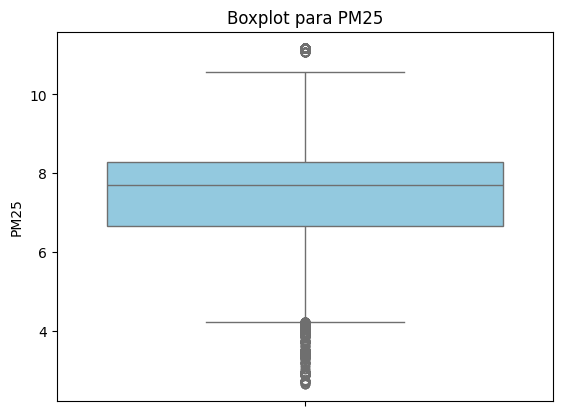

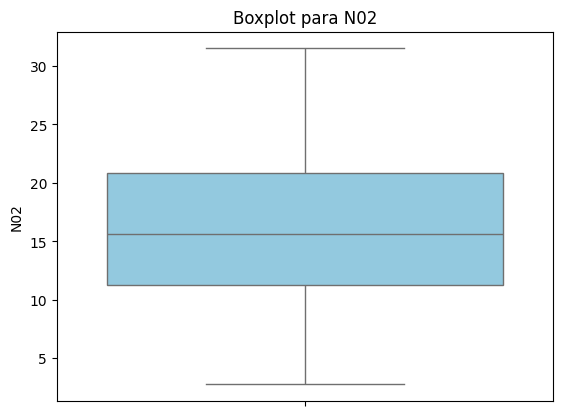

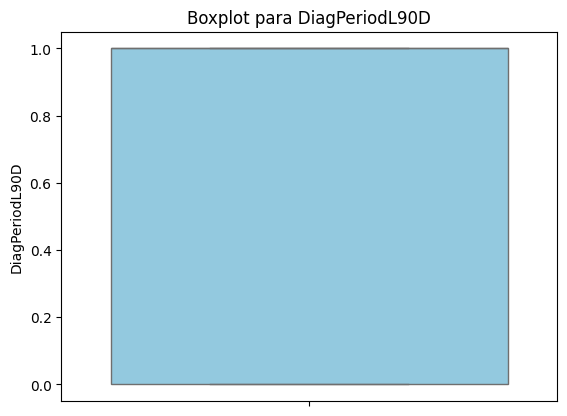

In [28]:
# Crear un boxplot para cada variable
for col in train[num_cols].columns:
    plt.figure()  # Crear una nueva figura para cada boxplot
    sns.boxplot(y=train[col], color='skyblue')
    plt.title(f'Boxplot para {col}')
    plt.show()

In [31]:
# Crear una función que nos ayude a determinar el % de nulos por columna

def porcentaje_nulos(dataframe):
    # Calcula el total de valores nulos por columna
    nulos_por_columna = dataframe.isnull().sum()

    # Calcula el porcentaje de valores nulos por columna
    porcentaje_nulos = (nulos_por_columna / len(dataframe)) * 100

    # Combina los resultados en un nuevo dataframe
    resumen_nulos = pd.DataFrame({
        'Columna': nulos_por_columna.index,
        'Valores Nulos': nulos_por_columna.values,
        '% Nulos': porcentaje_nulos.values
    })

    return resumen_nulos

In [42]:
resumen_nulos = porcentaje_nulos(train)
resumen_nulos

,Columna,Valores Nulos,% Nulos
0,patient_id,0,0.000000
1,patient_race,0,0.000000
2,payer_type,1125,17.251955
3,patient_state,35,0.536727
4,patient_zip3,0,0.000000
...,...,...,...
78,veteran,1,0.015335
79,Ozone,11,0.168686
80,PM25,11,0.168686
81,N02,11,0.168686


In [39]:
train = train.dropna(subset=['patient_race'])

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6521 entries, 1 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             6521 non-null   object 
 1   patient_race                           6521 non-null   object 
 2   payer_type                             5396 non-null   object 
 3   patient_state                          6486 non-null   object 
 4   patient_zip3                           6521 non-null   object 
 5   patient_age                            6521 non-null   int64  
 6   patient_gender                         6521 non-null   object 
 7   bmi                                    1985 non-null   float64
 8   breast_cancer_diagnosis_code           6521 non-null   object 
 9   breast_cancer_diagnosis_desc           6521 non-null   object 
 10  metastatic_cancer_diagnosis_code       6521 non-null   object 
 11  metastat

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6521 entries, 1 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             6521 non-null   object 
 1   patient_race                           6521 non-null   object 
 2   payer_type                             6521 non-null   object 
 3   patient_state                          6521 non-null   object 
 4   patient_zip3                           6521 non-null   object 
 5   patient_age                            6521 non-null   int64  
 6   patient_gender                         6521 non-null   object 
 7   bmi                                    1985 non-null   float64
 8   breast_cancer_diagnosis_code           6521 non-null   object 
 9   breast_cancer_diagnosis_desc           6521 non-null   object 
 10  metastatic_cancer_diagnosis_code       6521 non-null   object 
 11  metastat